In [30]:
%pylab inline
from scipy import signal as scipy

Populating the interactive namespace from numpy and matplotlib


# Senti Bioacoustic Signal Processing Architecture

This jupyter notebook details a proposal for the Senti bioacoustic signal processing firmware architecture. A jypter notebook was used as it makes it easy to tie together text and diagrams, along with code to demonstrate the concepts. The code is Python, which is pretty close to pseudocode, easily understood by most readers, and much more useful since it can actually be tested.

## Architecture

The architecture is a straight-forward signal processing pipeline.

![alt text](architecture.svg "Architecture Diagram")

The input buffer is acquired from the acoustic sensor module and contains an interleaved stereo buffer of signed 16 bit samples at a frequency of 44100Hz.

The buffer is first split to obtain the left and right channels, which contain the bioacoustic and background noise signals respectively. These signals are then subtracted to cancel out the noise from the bioacoustic signal. Following that the 44100Hz signal is downsampled to 4410Hz using an IIR anti-aliasing filter.

The resultant signal is then optionally encoded and then uploaded to the server, where it is ingested by the server and streamed to the web device.

These stages are discussed in more detail below.

## Prepare the input buffer

An authentic bioacouatic sample isn't available, so lets just construct something artificial to illustrate the concepts ;)

First initialize some constants:

In [31]:
fs = 44100
duration = 0.01
t = arange(0, duration, 1/fs)

Next, let's start with a single frequency of 250Hz. This is the signal we wish to recover after processing.

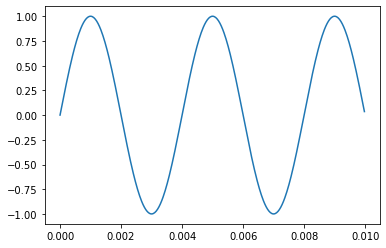

In [32]:
signal = sin(250 * t * 2 * pi)

plot(t, signal);

Now add a higher frequency with a lower amplitude which is outside our range of interest, but which we wish to use to illustrate the function of the anti-aliasing filter below.

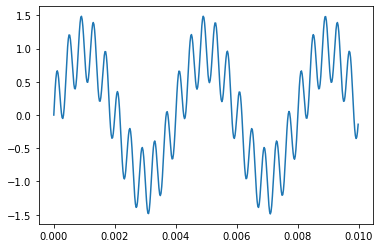

In [33]:
signal = add(signal, 0.5 * sin(2500 * t * 2 * pi))

plot(t, signal);

Next add a little noise to the signal:

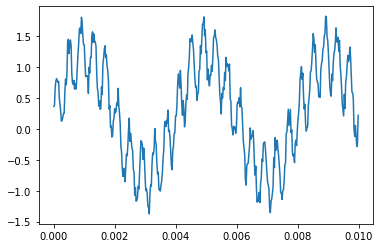

In [34]:
noise = 0.4 * random.rand(len(t),)
signal = add(signal, noise)

plot(t, signal);

Finally combine the bioacoustic signal and noise into a stereo interleaved buffer of signed 16 bit samples.

In [35]:
gain = (2**15 - 1) / max(abs(signal))
buffer = empty(signal.size * 2, dtype=int16)
buffer[::2] = (signal * gain).astype(int16)
buffer[1::2] = (noise * gain).astype(int16)

## Noise Cancellation

The audio buffer is an interleaved stereo buffer with two audio channels, one for the bioacouatic signal and the other for the background noise. The noise can be removed from the biacoustic signal by simply substracting the interleaved signals, i.e. subtract the odd numbered samples from the even numbered samples.

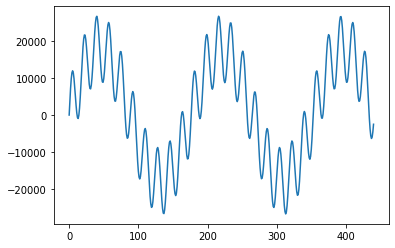

In [36]:
noise_cancelled = buffer[::2] - buffer[1::2] 

plot(range(noise_cancelled.size), noise_cancelled);

The result is a perfect signal with just the original frequencies present. In the real world, noise cancellation would not be so effective, but should still be useful to remove significant background noise.

## Downsample

The (now single channel) 44100Hz audio buffer needs to be downsampled to 4410Hz. If done in a naive way, this could cause the higher frequency components of the signal to be aliased to a lower frequencies, corrupting the output signal. Hence downsampling should include a low pass (anti-aliasing) filter to first remove any frequencies that cannot be represented by the new lower sampling frequency.

The decimate function below includes an IIR anti-aliasing low pass filter, and decimates by a factor of 10, from 44100Hz to 4410Hz.

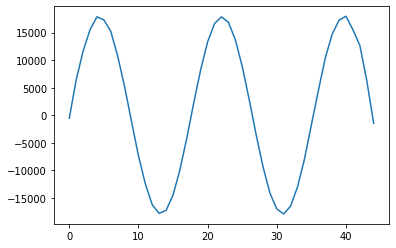

In [37]:
output = array(scipy.decimate(noise_cancelled, 10), dtype=int16)

plot(range(output.size), output);

The original bioacoustic signal has been recovered, ready for upload to the cloud web server over the 4G internet connection.

Note that plot only 45 samples, in comparision with the 450 samples in the earlier plot, prior to downsampling.

The higher frequency 2500Hz signal has been removed as part of the decimatation (by the anti-aliasing low pass filter), since according to the sampling theorem, with a 4410Hz sampling frequency the maximum frequency that can be represented is 2205Hz (half the sampling frequency).

## Encode and Upload

Before uploading to the server, the signal chunks could be encoded using an audio codec such as MP3 or AAC. This may reduce the size of the data to be sent over the 4G connection, hence reducing costs and bandwidth requirements. However this would require additional processing resources and since the sample already has such a low sampling frequency it is unclear whether encoding at this stage would offer any significant advantage. (see Ingest and Streaming section for discussion about encoding on the server).

To enable streaming the signal should be uploaded to the cloud web server in small chunks. Presumably this is already the case since the signal has been polled from the acoustic sensor in 30 second blocks. Typical chunk size for streaming would be 2-10 seconds of audio, but experimentation might be necessary to choose the optimum size for this application.

The upload protocol could be RTMP (Real Time Messaging Protocol), which is commonly used for streaming ingest (e.g YouTube), although since both ends of the communicate are within the system boundaries, it could just as easily be any simple TCP/IP based protocol that enables samples to be sent in chunks.

## Ingest and Streaming

As the sample chunks are received (ingested) on the cloud web server, the server needs to store them and update the necessary index files to enable streaming via typical protocols such as HLS or MPEG-DASH, both of which are supported on modern web browsers and mobile devices.

If the chunks are not already encoded in a recognised audio codec such as MP3 or AAC, they would need to be re-encoded. At this stage, encoding is not so much to reduce storage requirements, but more about compatibility with the widest range of streaming protocols and devices. It may be necessary to encode multiple copies of the chunks using different codecs in order to support the widest range of streaming protocols and gain the widest possible device support. This shouldn't present any significant challenge, since it is assumed that the server has no signicant constraints on processing resources.

It is also assumed that the server will perform various other computations on the incoming signals to elicit medical diagnostic parameters, which may also be made available via the web interface.